# Test Basel S12

In [161]:
import torch as torch
from torch.utils.data import *
import torch.nn.functional as F
import numpy as np
from os import path
from baselS12model import *
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TEST_PATH = '/home/user/notebooks/data/test'
MODEL_PATH = '/home/user/notebooks/data/model/baselS12'
MODEL_SAVED = MODEL_PATH + '/baselS12.pth'

## Plot Losses

In [3]:
checkpoint = torch.load(MODEL_SAVED)

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

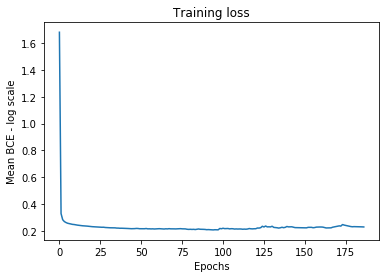

In [5]:
plt.plot(np.log(moving_average(checkpoint['train_losses'], 1)))
plt.xlabel("Epochs")
plt.ylabel('Mean BCE - log scale')
plt.title('Training loss')
plt.savefig(MODEL_PATH+'/training_loss.png', dpi=200)

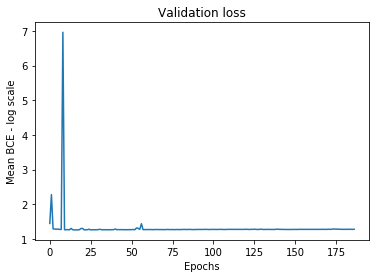

In [6]:
plt.plot(checkpoint['valid_losses'])
plt.xlabel("Epochs")
plt.ylabel('Mean BCE - log scale')
plt.title('Validation loss')
plt.savefig(MODEL_PATH+'/valid_loss.png', dpi=200)

## Model Performance on Test Data

In [7]:
test_acq, test_idx_to_seq, test_seq = load_data(TEST_PATH)

  0%|          | 0/1 [00:00<?, ?it/s]

Acquisition numpy: /home/user/notebooks/data/test/fnm_input_acq.npy
Sequence numpy: /home/user/notebooks/data/test/fnm_input_seq_*.npy
Index to Sequence Index numpy: /home/user/notebooks/data/test/fnm_input_idx_to_seq.npy
loading seq_numpy_chunk


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


In [8]:
test_ds = FNMDatasetS12(test_acq, test_idx_to_seq, test_seq)

In [9]:
DEBUG = False
if DEBUG:
    BATCH_SIZE = 4
    NUM_WORKERS = 0 
else:
    BATCH_SIZE = 512 #12*2**10
    NUM_WORKERS = 16
LOSS_EVERY_N_BATCHES=200

In [10]:
print("Number of test acq: {:,}".format(len(test_ds)))

Number of test acq: 2,541,531


In [11]:
testDL = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=paddingCollator, num_workers=NUM_WORKERS)

In [138]:
if DEBUG:
    device = torch.device('cpu')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


acq_embs = makeEmeddings(test_acq, embeding_dim=2)

model = BaselS12Model(seq_n_features=22, lstm_size=100, lstm_layers=3, lstm_dropout=0.3, embed_dims = acq_embs)
loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(params=model.parameters())
checkpoint_epoch = 0
test_losses = []

# Load Model weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [139]:
model = model.to(device)
loss_function = loss_function.to(device)

In [140]:
if not DEBUG:
    if torch.cuda.device_count() > 1:
        print("Training on", torch.cuda.device_count(), "GPUs")
        model = nn.DataParallel(model)

Training on 2 GPUs


In [141]:
target_vec = np.zeros((len(test_ds), 12), dtype=np.int32)
target_hat_mat = np.zeros((len(test_ds), 19, 12), dtype=np.float32)
last_dlq = -1*np.ones((len(test_ds)))

In [142]:
test_losses = []

In [168]:
model.eval()
for bidx, (seq, seq_len, acq, target) in enumerate(tqdm(testDL)):
    target_vec[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE, :] = target.detach().cpu().numpy()
    last_dlq[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE] = np.argmax(seq[:, -1, :19].detach().cpu().numpy())
    seq = seq.to(device)
    acq = acq.to(device)
    seq_len = seq_len.to(device)
    target = target.to(device)
    target_hat = model(seq, seq_len, acq)
    target_hat = F.softmax(target_hat, dim=1)
    
    target_hat_mat[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE, :, :] = target_hat.detach().cpu().numpy()


100%|██████████| 4964/4964 [03:11<00:00, 25.95it/s]

In [145]:
print('Testing error: {}'.format(np.sum(test_losses)/len(test_losses)/BATCH_SIZE))

Testing error: 0.827960409133978


## Build ROC curves

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Calculate corresponding 1 year default rate

In [149]:
dlq_predicted = np.argmax(target_hat_mat, axis=1)
defaults_predicted = 1*(np.max(dlq_predicted, axis=1) > 6)

In [229]:
defaults_predicted.shape

(2541531,)

In [180]:
def_score = np.sum(target_hat_mat[:, 7:, :], axis=1)

In [230]:
def_score.shape

(2541531, 12)

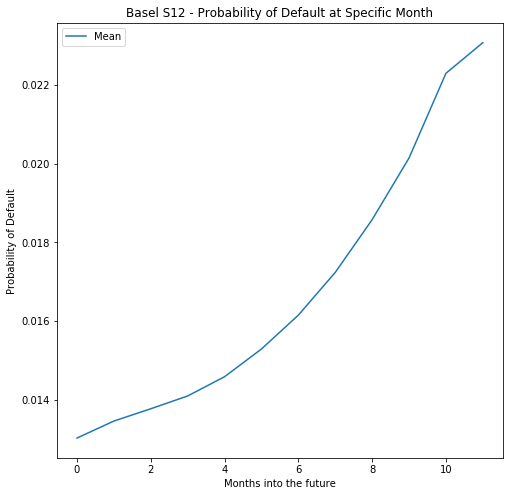

In [204]:
plt.figure(1, figsize=[8, 8])
plt.plot(np.mean(def_score, axis=0), label='Mean')
plt.xlabel('Months into the future')
plt.ylabel('Probability of Default')
plt.title('Basel S12 - Probability of Default at Specific Month')
plt.legend(loc='best') 
plt.savefig(MODEL_PATH+'/mean_pd.png', dpi=200)

In [213]:
def1y_score = 1-np.prod(1-def_score, axis=1)
def1y_target = 1*(np.max(target_vec, axis=1) >= 7)

In [214]:
last_dlq.shape

(2541531,)

In [222]:
fpr = dict()
tpr = dict()
roc_auc = dict()

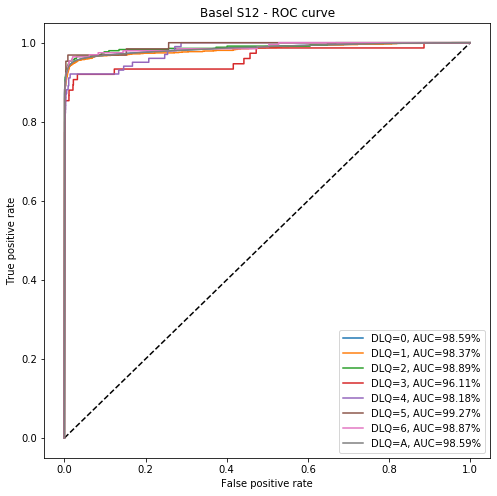

In [224]:
plt.figure(1, figsize=[8, 8])
plt.plot([0, 1], [0, 1], 'k--')
for dlq in range(7):
    idx = np.where(last_dlq==dlq)
    fpr[dlq], tpr[dlq], _ = roc_curve(def1y_target[idx], def1y_score[idx])
    roc_auc[dlq] = auc(fpr[dlq], tpr[dlq])
    plt.plot(fpr[dlq], tpr[dlq], label='DLQ={}, AUC={:.2f}%'.format(dlq, roc_auc[dlq]*100))
fpr[-1], tpr[-1], _ = roc_curve(def1y_target, def1y_score)
roc_auc[-1] = auc(fpr[-1], tpr[-1])
plt.plot(fpr[-1], tpr[-1], label='DLQ=A, AUC={:.2f}%'.format(roc_auc[-1]*100))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Basel S12 - ROC curve')
plt.legend(loc='best')
plt.savefig(MODEL_PATH+'/def1y_roc.png', dpi=200)

### Build Multiclass ROC

In [146]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [147]:
t = 11 # next month
dlq_score = target_hat_mat[0:, :, :]
dlq_test = target_vec[0:, :]
dlq_test_bin = label_binarize(dlq_test[:, t], np.arange(19))

In [123]:
fpr[dlq], tpr[dlq], _ = roc_curve(dlq_test_bin[:, dlq], dlq_score[:, dlq, t])
roc_auc[dlq] = auc(fpr[dlq], tpr[dlq])

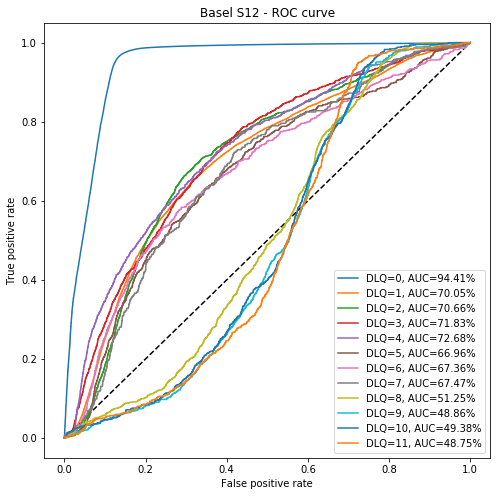

In [124]:
plt.figure(1, figsize=[8, 8])
plt.plot([0, 1], [0, 1], 'k--')
for dlq in range(12):
    fpr[dlq], tpr[dlq], _ = roc_curve(dlq_test_bin[:, dlq], dlq_score[:, dlq, t])
    roc_auc[dlq] = auc(fpr[dlq], tpr[dlq])
    plt.plot(fpr[dlq], tpr[dlq], label='DLQ={}, AUC={:.2f}%'.format(dlq, roc_auc[dlq]*100))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Basel S12 - ROC curve')
plt.legend(loc='best')

## Display Embeddings

In [107]:
model = BaselS12Model(seq_n_features=22, lstm_size=100, lstm_layers=3, lstm_dropout=0.3, embed_dims = acq_embs)

In [102]:
import pandas as pd

In [111]:
state = ['XX',
'AK',
'AL',
'AR',
'AZ',
'CA',
'CO',
'CT',
'DC',
'DE',
'FL',
'GA',
'GU',
'HI',
'IA',
'ID',
'IL',
'IN',
'KS',
'KY',
'LA',
'MA',
'MD',
'ME',
'MI',
'MN',
'MO',
'MS',
'MT',
'NC',
'ND',
'NE',
'NH',
'NJ',
'NM',
'NV',
'NY',
'OH',
'OK',
'OR',
'PA',
'PR',
'RI',
'SC',
'SD',
'TN',
'TX',
'UT',
'VA',
'VI',
'VT',
'WA',
'WI',
'WV',
'WY']

In [113]:
states_emb = model.embed_layers[0](torch.arange(0,55)).detach().numpy()

<Figure size 576x576 with 0 Axes>

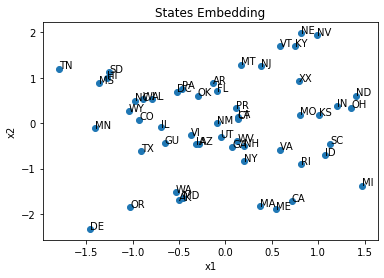

In [115]:
plt.figure(1, figsize=[8, 8])
fig, ax = plt.subplots()
ax.scatter(states_emb[:, 0], states_emb[:, 1])

for i, st in enumerate(state):
    ax.annotate(st, (states[i, 0], states[i, 1]))
plt.xlabel("x1")
plt.ylabel('x2')
plt.title('States Embedding')
plt.savefig(MODEL_PATH+'/state_embedding.png', dpi=200)

In [118]:
zip3 = pd.read_csv(MODEL_PATH + '/fnm_zip3.csv', names = ['zip_id', 'zip3'], header=None, sep='|', dtype={'zip_id': np.int32, 'zip3':'str'})

In [105]:
#zip3 = zip3.append(pd.DataFrame({'zip_id': [0], 'zip3': ['XXX']})).sort_values('zip_id')

In [126]:
model.embed_layers[7]

Embedding(1001, 2)

In [117]:
zip3['zip3'][0]

0    XXX
0    000
Name: zip3, dtype: object

In [119]:
zip3_emb = model.embed_layers[7](torch.arange(0,1001)).detach().numpy()

<Figure size 1296x1296 with 0 Axes>

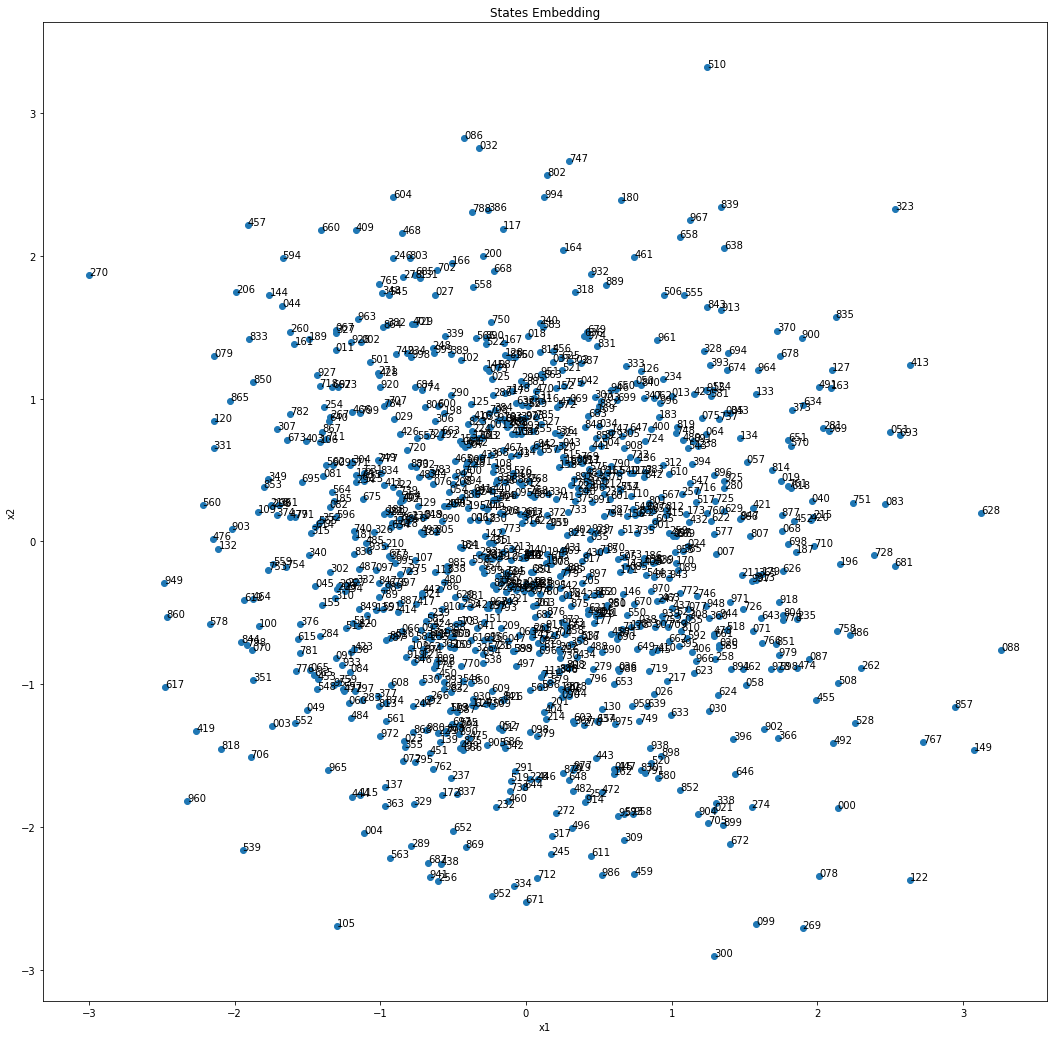

In [120]:
plt.figure(1, figsize=[18, 18])
fig, ax = plt.subplots(figsize=[18, 18])
ax.scatter(zip3_emb[:, 0], zip3_emb[:, 1])

for i, st in enumerate(zip3['zip3']):
    ax.annotate(st, (zip3_emb[i, 0], zip3_emb[i, 1]))
plt.xlabel("x1")
plt.ylabel('x2')
plt.title('States Embedding')
plt.savefig(MODEL_PATH+'/zip3_embedding.png', dpi=200)

## Seller Embedding

In [128]:
seller = pd.read_csv(MODEL_PATH + '/fnm_seller.csv', names = ['id', 'desc'], header=None, sep='|', dtype={'id': np.int32, 'desc':'str'})

In [129]:
model.embed_layers[6]

Embedding(95, 2)

In [132]:
seller_emb = model.embed_layers[6](torch.arange(0,95)).detach().numpy()

<Figure size 1296x1296 with 0 Axes>

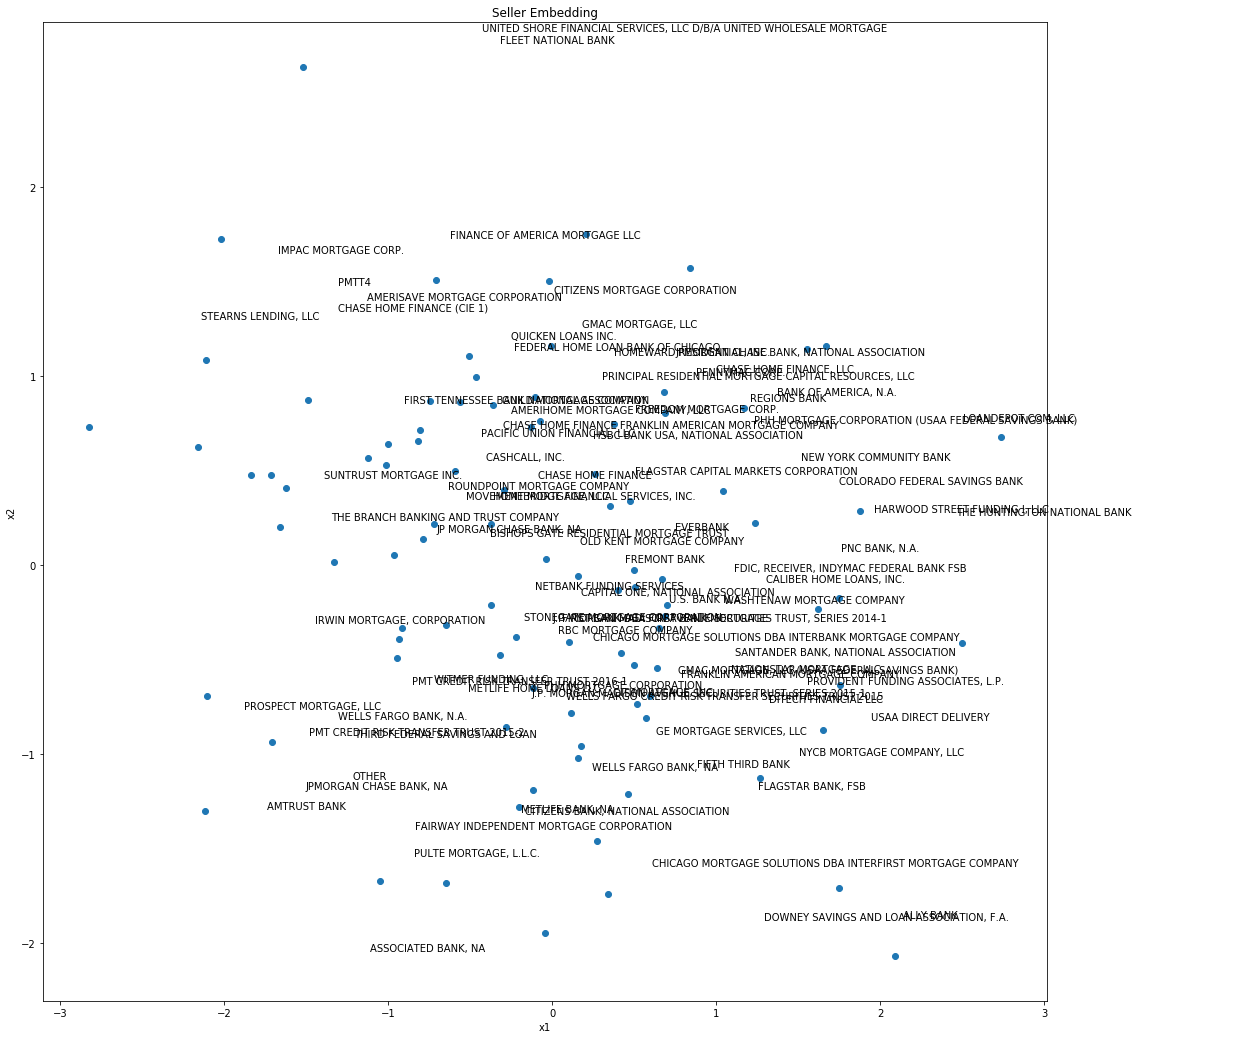

In [133]:
plt.figure(1, figsize=[18, 18])
fig, ax = plt.subplots(figsize=[18, 18])
ax.scatter(seller_emb[:, 0], seller_emb[:, 1])

for i, st in enumerate(seller['desc']):
    ax.annotate(st, (zip3_emb[i, 0], zip3_emb[i, 1]))
plt.xlabel("x1")
plt.ylabel('x2')
plt.title('Seller Embedding')
plt.savefig(MODEL_PATH+'/seller_embedding.png', dpi=200)